<a href="https://colab.research.google.com/github/ValentineAlibert/Data-physics/blob/master/(final1)%20ML_gym_reinforcement_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **CartPole-Reinforcement-Learning**


This code uses Policy gradient algorithm called REINFORCE to solve
OpenAI Gym's CartPole balancing proble 

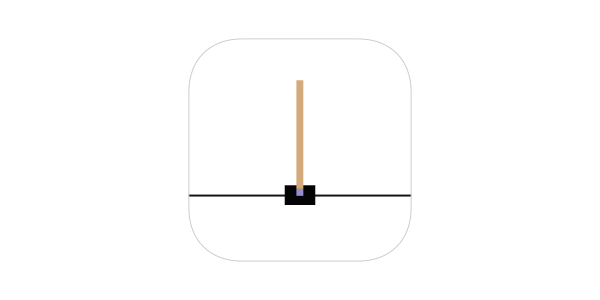

The cartpole problem is an inverted pendelum problem where a stick is balanced upright on a cart. The cart can be moved left or right to and the goal is to keep the stick from falling over. A positive reward of +1 is received for every time step that the stick is upright. When it falls past a certain degree then the "episode" is over and a new one can begin. CartPole can be found in OpenAI Gym's list of trainable environments. This project requires Python 3.5 with the Gym, numpy, and matplotlib libraries installed. The CartPole-V0 environment is used.

In 'agent.py', there are 3 agent classes defined, each with a different algorithm attached. The basic agent simply moves the cart left if the stick is leaning to the left and moves the cart right if the stick is leaning to the right. The random agent randomly chooses an action (left or right) for the cart to move at every time step. The Q-Learning agent uses a Q-Learning algorithm to choose the best action given the current observation of the cartpole.

When using Q-learning, 'stats.py' plots the agent parameters (alpha & epsilon), rewards per trial, and rolling average rewards per trial. This is useful for visualizing how well the algorithm is performing. (Information found on the code of enerrio on Github)

https://towardsdatascience.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288

** gym is a collection of environments to develop and test RL algorithms.  It’s built on a Markov chain model that is illustrated below.**

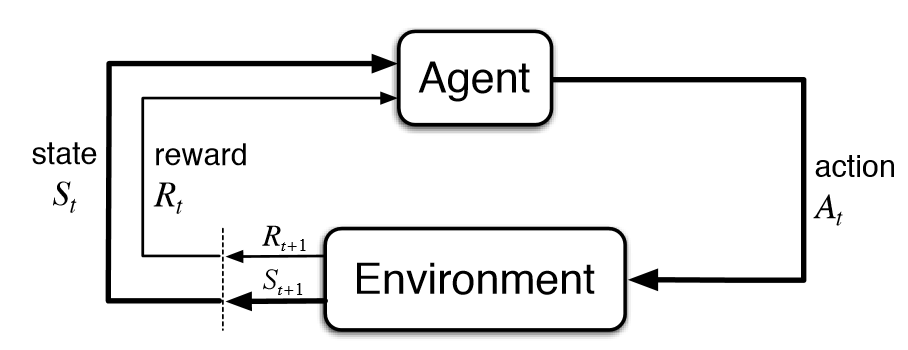

In [9]:
!pip install gym

In [0]:
COLAB = True

if(COLAB) :
  # install some helpers to visualize gym graphics in the colab environment
  !pip install gym pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [0]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf



In [0]:
# only necessary for visualisation in colab env.
if(COLAB) :
  from IPython.display import HTML
  from IPython import display as ipythondisplay
  from pyvirtualdisplay import Display
  from gym.wrappers import Monitor
  import glob, io, os, base64
  from moviepy.editor import VideoFileClip, concatenate_videoclips

  display = Display(visible=0, size=(1400, 900))
  display.start()
  os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

  def combine_videos() :
    mp4list = sorted( glob.glob('video/*.mp4') )
    if len(mp4list) > 0 :
      videolist = []
      for mp4 in mp4list :
        videolist.append( VideoFileClip(mp4))
      final_clip = concatenate_videoclips(videolist)
      final_clip.to_videofile("combined.mp4", fps=24, remove_temp=False)
      return 1
    else :
      return 0

  def show_video() :
      if(combine_videos()) :
        video = io.open("combined.mp4", 'r+b').read()

        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded.decode('ascii'))))
      else :
        print("Error: no videos found")     


  def wrap_env(env):
    env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True)
    return env


In [0]:

ENV_NAME= "CartPole-v1"


MAXRUNS = 35
#NSTEPSOLVED = 1000

GAMMA = 0.95  # 'future discount factor'
LEARNING_RATE = 0.01 # rate at which to update weights after each training step

MEMORY_SIZE = 100000 # size of container to hold actions and outcomes
BATCH_SIZE = 34 # number of actions in memory to 'replay' after each death

# probability to do 'random' actions, to sample from event space
EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995   


In [0]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        # This will be a simple feed-forward NN, with 
        #  - input = 'observation' (aka state)
        #  - output = predicted 'quality' of each possible action
       
        
        ### STUDENT CODE HERE ###
        ### --> Write the network using fully-connected (Dense) layers.
        
        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=0.001))
        self.model.summary()

        ###  Make sure the input has the same shape as an observation/state,
        ###   and the output has the same dimensions as the number of possible actions.
        ### END STUDENT CODE ###
        
   
    def remember(self, state, action, reward, next_state, done):
        # add event to memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # return the best possible action for the current state

        # sometimes allow for a random action at the 'exploration rate', to avoid local minima
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        
        # Get predicted qualities for each possible action, and return the action (=index) with the highest quality
        q_values = self.model.predict(state) 
        return np.argmax(q_values[0])

    def experience_replay(self):
        # Learn from random subset of memory (reduces corr. between subsequent actions).
        # learning is done by comparing 'predicted quality' to the here defined quality (~reward) of the action.
        
        if len(self.memory) < BATCH_SIZE:
            # We haven't experienced enough to properly learn yet - keep exploring!
            return
        
        # Get random subset of memory
        batch = random.sample(self.memory, BATCH_SIZE) 
        
        for state, action, reward, state_next, terminal in batch:

            # We define the 'quality' of a move by taking the known, memorized reward for the action,
            #  and adding the predicted quality of the (predicted) best choice of action for the next state, to that.
            # As the model learns to give this situation a low quality, any step leading up to this state will get a 
            #  lower quality due to the predict(state_next) term. This will slowly trickle through to the step before that, etc.,
            #  slowly making our agent learn about future consequences of current actions.
          
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                
                # One could try to make the model learn from intermediate steps directly as well, speeding up the learning,
                #  e.g. by changing the reward based on an increase in angle (although this should really be defined in the env.)
                #q_update -= 1.0 * abs(state_next[0][2]) - abs(state[0][2]) # penalize angle increases for cartpole
                
            # - Define the quality of the non-chosen action to just be the predicted quality (i.e. diff = 0)
            # - Define the quality of the chosen action to be the newly defined quality
            q_values = self.model.predict(state)
            q_values[0][action] = q_update 
            
            # Finally, find the optimal model weights for minimal difference between 
            #  predicted quality and observed quality (+ future prediction as per above) for this action.
            # The weights are then updated * learning rate
            self.model.fit(state, q_values, verbose=0) 
            
        # reduce the 'random choices' rate over time, because you expect the model to have learned
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [0]:
def cartpole() :
    if(COLAB) : env = wrap_env(gym.make(ENV_NAME)) # only for visualisation in colab
    else : env = gym.make(ENV_NAME)

    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
       
    run=0
    runsteplog = []
    #while True:
    for i in range(MAXRUNS):
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        
        while True :    
            step += 1
            screen = env.render() # graphical output


            
            ### STUDENT CODE HERE
            ### --> Redefine the action to be the output of the 'act' of your solver.
            action = dqn_solver.act(state) # (this takes a random action)
            ### END STUDENT CODE
            
            # make the action
            state_next, reward, terminal, info = env.step(action) 

            # if action made terminal: reduce reward!
            reward = reward if not terminal else -reward  

            state_next = np.reshape(state_next, [1, observation_space])

            # fill agent memory with this action's results
            dqn_solver.remember(state, action, reward, state_next, terminal) 

            # prepare for the next action in the environment
            state = state_next 
            
            if terminal :
                #state = env.reset()
                #state = np.reshape(state, [1, observation_space])
                print("Run: {0}, exploration: {1:.15f}, score: {2}".format(run,dqn_solver.exploration_rate,step))
                runsteplog += [step]

                break
            
            dqn_solver.experience_replay() # learn from batch of memories every time a new one is made
            
            #if(step > NSTEPSOLVED) :
            #    i = MAXRUNS
            #    print("Solved! (step > NSTEPSOLVED)")
            #    break


    env.close()
    


    # Show training process
    
    # plot #steps achieved
    plt.plot(runsteplog)
    plt.ylabel("# actions before terminal")
    plt.xlabel("run iteration")

    success_measure = np.mean(runsteplog[-15:])
    print("Mean of last 15 runs: {0}".format(success_measure))
    return success_measure

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Run: 1, exploration: 1.000000000000000, score: 11
Run: 2, exploration: 0.990025000000000, score: 25
Run: 3, exploration: 0.818320121022674, score: 39
Run: 4, exploration: 0.774420994283299, score: 12
Run: 5, exploration: 0.693561367831317, score: 23
Run: 6, exploration: 0.518589330948458, score: 59
Run: 7, exploration: 0.399598432971326, score: 53
Run: 8, exploration: 0.3490173016974

100%|██████████| 3278/3278 [00:20<00:00, 158.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: combined.mp4 



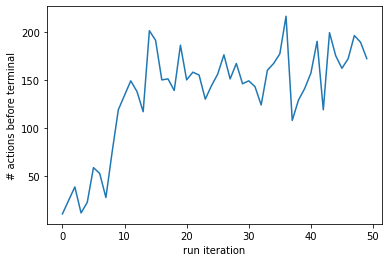

In [16]:
MAXRUNS = 50

if __name__ == "__main__":
    cartpole()

if(COLAB) :
    show_video() 